取得 台指期 與小外資 投信連線

In [1]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime, timedelta

# 設置MySQL資料庫連接
db_user = 'root'
db_password = '19970730'
db_host = '127.0.0.1'
db_name = 'sql_stock'

# 創建資料庫連接引擎
engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}')

# 設置日期範圍
#today = datetime(2024, 5, 25)
today = datetime.now().date()
one_year_ago = today - timedelta(days=1000)

# 格式化日期
today_str = today.strftime('%Y%m%d')
one_year_ago_str = one_year_ago.strftime('%Y%m%d')

# 可自由調整select的區間
# today_str = '20240813'
today_str = '20241231'
one_year_ago_str = '20210101'

# SQL 查詢 加權指數
query_daily_tx = f"""
SELECT *
FROM daily_tx
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 加權指數
query_tif_investors = f"""
SELECT *
FROM daily_tif_investors
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
tif_investors_df_raw = pd.read_sql(query_tif_investors, engine)
# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
tx_df_raw = pd.read_sql(query_daily_tx, engine)

In [2]:
tif_investors_df_raw
# 五大特定淨部位
top5_sp = tif_investors_df_raw['買方前五大交易人合計'] - tif_investors_df_raw['賣方前五大交易人合計']
# 大外資 = 五大減投信 (投信應該依定會進去前五大)
big_foreign = top5_sp - tif_investors_df_raw['投信未平倉餘額口數']
# 小外資
small_foreign = tif_investors_df_raw['外資未平倉餘額口數'] - big_foreign

tif_investors_df_raw['大外資']  = big_foreign
tif_investors_df_raw['小外資']  = small_foreign



# 将 'Date' 列转换为 datetime 类型
tif_investors_df_raw['Date'] = pd.to_datetime(tif_investors_df_raw['Date'])
tx_df_raw['Date'] = pd.to_datetime(tx_df_raw['Date'])  # 假设你有一个 Date 列


tx_df_raw.loc[:, '5MA'] = tx_df_raw['最後成交價'].rolling(5).mean()
tx_df_raw.loc[:, '8MA'] = tx_df_raw['最後成交價'].rolling(8).mean()
tx_df_raw.loc[:, '10MA'] = tx_df_raw['最後成交價'].rolling(10).mean()
tx_df_raw.loc[:, '20MA']= tx_df_raw['最後成交價'].rolling(20).mean()
tx_df_raw.loc[:, '60MA']= tx_df_raw['最後成交價'].rolling(60).mean()
tx_df_raw.loc[:, '240MA']= tx_df_raw['最後成交價'].rolling(240).mean()

tx_df_raw = tx_df_raw.fillna(0)


畫畫前準備 設定INDEX (不可重複設定)

In [ ]:
# 畫畫前準備資料
# 將欄位名稱改為 'Open', 'High', 'Low', 'Close'
tx_df_forplot = tx_df_raw.copy()
tif_investors_forplot = tif_investors_df_raw.copy()
tx_df_forplot.rename(columns={'開盤價': 'Open', '最高價': 'High', '最低價': 'Low', '最後成交價': 'Close'}, inplace=True)
tx_df_forplot.set_index('Date', inplace=True)
tif_investors_forplot.set_index('Date', inplace=True)

可透過 plot_size 調整繪畫的尺度 (單位:天數)

In [5]:
# 畫畫要畫幾天的資料
plot_size = 100

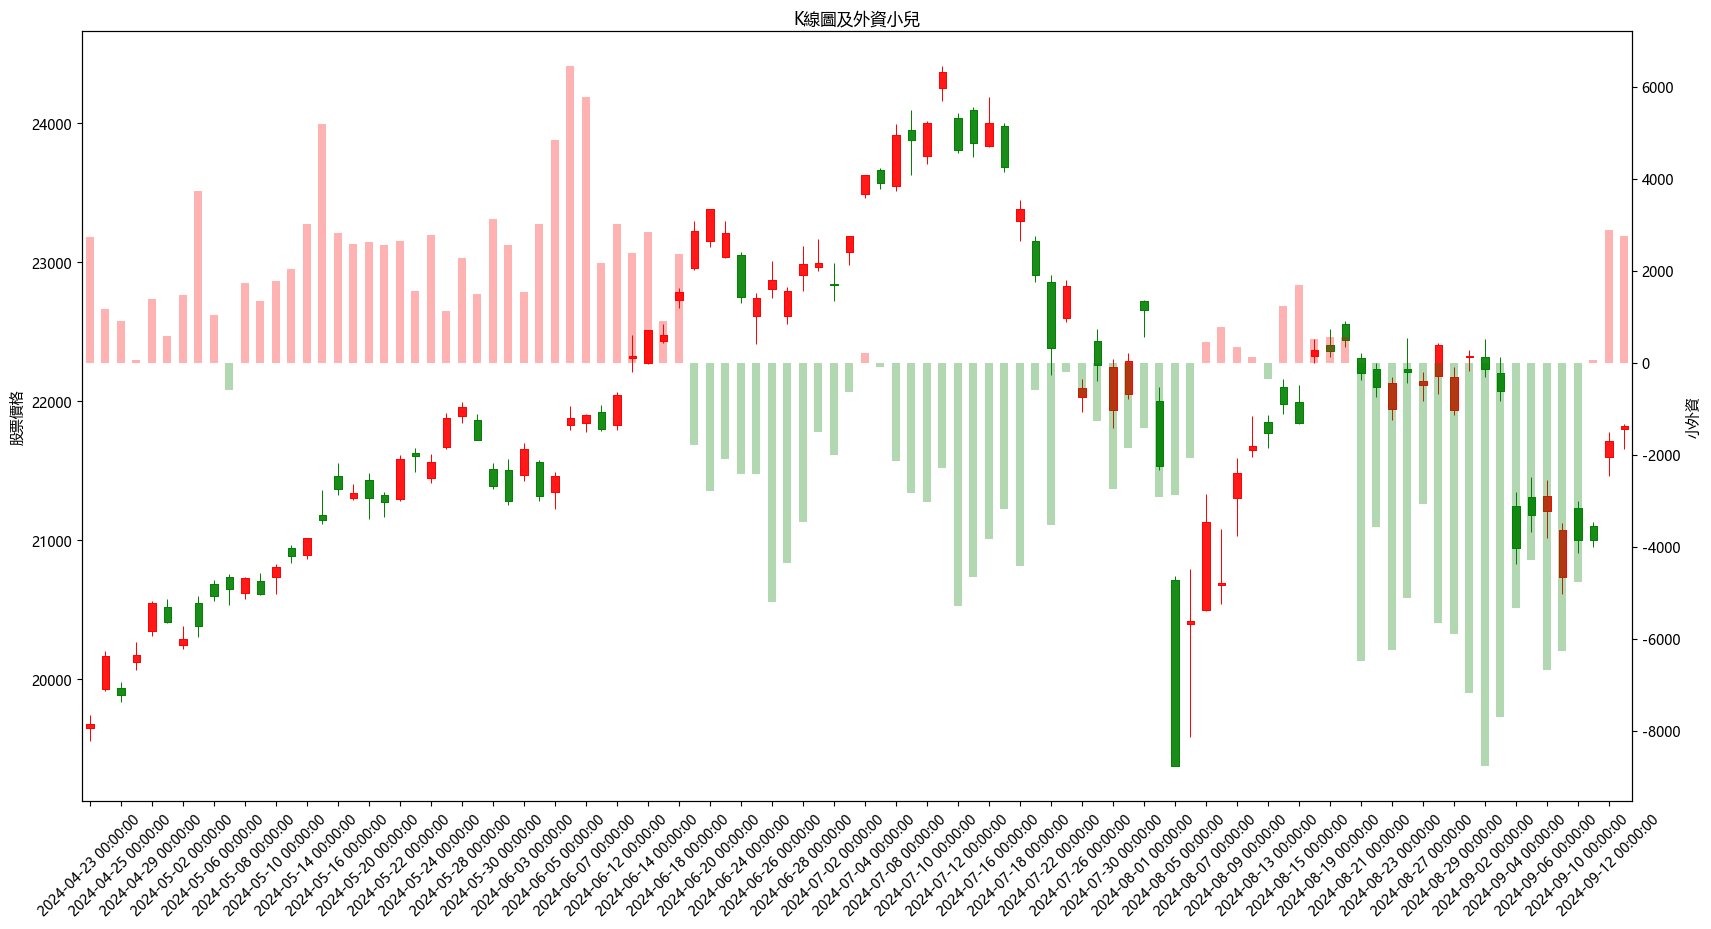

In [9]:
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


tx_df_raw_100 = tx_df_forplot.tail(plot_size)
tif_investors_df_raw_100 = tif_investors_forplot.tail(plot_size)


# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題


# 假設你的 dataframe 含有必要的 OHLC 數據 (Open, High, Low, Close)
ohlc_data = tx_df_raw_100[['Open', 'High', 'Low', 'Close']]

# 自定義顏色樣式，上漲為紅色，下跌為綠色
my_color = mpf.make_marketcolors(up='red', down='green', edge='inherit', wick='inherit', volume='inherit')

# 自定義樣式
my_style = mpf.make_mpf_style(marketcolors=my_color)

# 設置主圖和次圖
fig, ax1 = plt.subplots(figsize=(20,10))

# 繪製蠟燭圖到 ax1，使用自定義的顏色樣式
mpf.plot(ohlc_data, type='candle', ax=ax1, volume=False, style=my_style)

# 設定 x 軸只顯示日期
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 格式化日期顯示
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())  # 自動設置日期間隔

# 旋轉 x 軸標籤以便更清楚顯示
plt.xticks(rotation=45)

# 創建一個共享 X 軸但有不同 Y 軸的次圖 ax2
ax2 = ax1.twinx()

# 繪製小外資的正負長條圖到 ax2
tif_investors_df_raw_100['小外資'].plot(kind='bar', 
                                       color=['red' if v >= 0 else 'green' for v in tif_investors_df_raw_100['小外資']],
                                       ax=ax2, alpha=0.3)  # 調整透明度以顯示蠟燭圖

ax1.set_xticks(ax1.get_xticks()[::2])  # 每隔5个标签显示一个

# 繪製 10MA 移動平均線到 ax1
#ax1.plot(tx_df_raw['10MA'].index, tx_df_raw['10MA'], label='10MA', color='blue', linewidth=2)

# 設定標題和軸標籤
plt.title('K線圖及外資小兒')
ax1.set_ylabel('股票價格')
ax2.set_ylabel('小外資')

# 顯示圖表
plt.show()


In [ ]:
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

# 假設你的 dataframe 含有必要的 OHLC 數據 (Open, High, Low, Close)
ohlc_data = tx_df_raw_100[['Open', 'High', 'Low', 'Close']]

# 自定義顏色樣式，上漲為紅色，下跌為綠色
my_color = mpf.make_marketcolors(up='red', down='green', edge='inherit', wick='inherit', volume='inherit')

# 自定義樣式
my_style = mpf.make_mpf_style(marketcolors=my_color)
my_addplot_ma = mpf.make_addplot(tx_df_raw_100['10MA'], color='blue')

# 創建長條圖的附加圖
my_addplot_investors = mpf.make_addplot(tif_investors_df_raw_100['小外資'], 
                                         type='bar', 
                                         color=['red' if v >= 0 else 'green' for v in tif_investors_df_raw_100['小外資']],
                                         alpha=0.3)

# 繪製蠟燭圖並添加 10MA 和小外資長條圖
mpf.plot(ohlc_data, 
         type='candle', 
         style=my_style, 
         addplot=[my_addplot_ma, my_addplot_investors],
         volume=False,
         title='股票蠟燭圖及小外資與10MA',
         ylabel='股票價格 (Open, High, Low, Close)',
         ylabel_lower='小外資',
         figratio=(20, 20), 
         datetime_format='%Y-%m-%d',
         xrotation=45)

# 顯示圖表
plt.show()


📌訊號：小外資由空翻多，或由多翻空

📌進場：等待加權站上或跌破10日均線，日盤尾盤進場，與小外資同向

📌反向則不進場：例如如小外資是空單，加權站上10均，不進場空手觀望

📌主觀認為進入盤整段也不會進場，或是縮小部位以免雙巴到懷疑人生

📌加碼：
跌破/站上10均後反彈至10均或5均，加碼

📌出場策略：
多方：加權跌破10均出場
空方：盤面恐慌急殺時出場


In [192]:
import numpy as np
import warnings
# 計算訊號出來後隔天開盤直接買
# 出場訊號出來後 隔天開盤直接賣
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

MA = '10MA'

tx_df_raw = tx_df_raw[tx_df_raw[MA] != 0]
# tx_df_raw[tx_df_raw['最後成交價'] >= tx_df_raw['10MA']]
tif_investors_df_raw['小外資變化'] = tif_investors_df_raw['小外資'].diff(1)
tif_investors_df_raw.dropna()

# 使用 'Date' 欄位進行內部連接
merged_df = pd.merge(tif_investors_df_raw, tx_df_raw, on='Date', how='inner')

merged_df['hold'] = np.nan

condition_buy = ((merged_df['最後成交價'] >=  merged_df[MA]) & (merged_df['小外資變化'] > 0))

condition_sell = (merged_df['最後成交價'] <  merged_df[MA])

merged_df.loc[condition_buy, 'hold'] = 1
merged_df.loc[condition_sell, 'hold'] = 0

merged_df['hold'].ffill(inplace=True)
merged_df['hold'] = merged_df['hold'].fillna(0)

# 計算進出

day_list = merged_df['Date'].unique().tolist()
earm_data1 = pd.DataFrame(columns=['buy_date','sell_date','buy_open','sell_open','earn'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = merged_df[merged_df['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天

                close = merged_df[merged_df['Date'] > today_str]['最後成交價'].iloc[0] 
                ma10 = merged_df[merged_df['Date'] > today_str][MA].iloc[0] 

                if (close >=  ma10):
                        #隔天收盤要站上再買進
                        buy_close = merged_df[merged_df['Date'] > today_str]['最後成交價'].iloc[0] 
                        buy_date = merged_df[merged_df['Date'] > today_str]['Date'].iloc[0] 


                        #跌破ma當天
                        sell_open = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['最後成交價'].iloc[0] 
                        sell_date = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['Date'].iloc[0] 
                        sell_date = pd.to_datetime(sell_date)

                        earn = sell_open - buy_close

                        result_df = pd.DataFrame({
                                'buy_date': [buy_date],
                                'sell_date': [sell_date],
                                'buy_open': [buy_close],
                                'sell_open': [sell_open],
                                'earn': [earn]
                                })

                        # 删除全为NA的列，避免可能出现的警告
                        result_df.dropna(axis=1, how='all', inplace=True)

                        if not result_df.empty:
                                earm_data1 = pd.concat([earm_data1, result_df], ignore_index=True)

        
# earm_data1['cumsum'] = earm_data1['earn'].cumsum()
# earm_data1



===大盤累積====
5421.0
===外資小兒法累積====
5092.0
===進出次數====
40
===第一次買進===
2021-10-18 00:00:00
===最後一次賣出===
2024-08-27 00:00:00


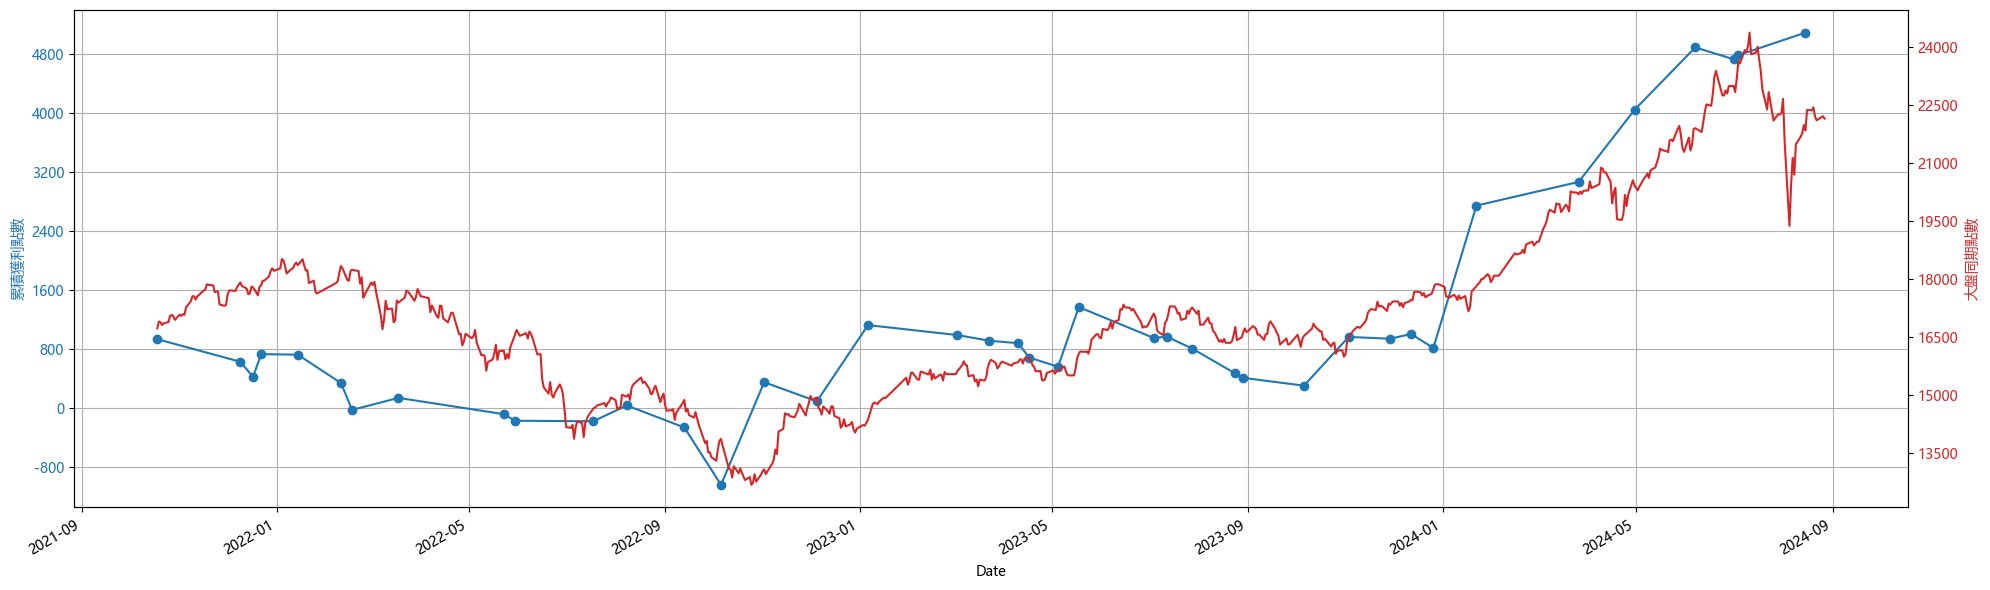

In [193]:
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.ticker import MaxNLocator

# 同期大盤資料 
tx_df = merged_df[( merged_df['Date'] >=  earm_data1['buy_date'].iloc[0]) & (merged_df['Date'] <= earm_data1['sell_date'].iloc[-1])]

print('===大盤累積====')
print(tx_df['最後成交價'].iloc[-1] - tx_df['最後成交價'].iloc[0])

print('===外資小兒法累積====')
print(earm_data1['earn'].cumsum().iloc[-1])

print('===進出次數====')
print(len(earm_data1))

print('===第一次買進===')
print(earm_data1['buy_date'].iloc[0])

print('===最後一次賣出===')
print(earm_data1['sell_date'].iloc[-1])

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題


# 假設 'Date' 已經是日期格式
fig, ax1 = plt.subplots(figsize=(20, 6))

# 第一條線 - 最後成交價
ax1.set_xlabel('Date')
ax1.set_ylabel('累積獲利點數', color='tab:blue')
ax1.plot(earm_data1['buy_date'], earm_data1['earn'].cumsum(), color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 開啟網格
ax1.grid(True)
# 調整 Y 軸間距 (設定更多標籤)
ax1.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 建立第二個Y軸
ax2 = ax1.twinx()  
ax2.set_ylabel('大盤同期點數', color='tab:red')  # 可以根據需要調整標籤
ax2.plot(tx_df['Date'], tx_df['最後成交價'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# 調整第二個 Y 軸間距 (同樣設定更多標籤)
ax2.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 旋轉日期標籤
fig.autofmt_xdate()

# 顯示圖表
fig.tight_layout()
plt.show()


In [28]:
# merged_df[(merged_df['Date'] >= '2024-07-01') & (merged_df['Date'] <= '2024-07-10')][['Date', '開盤價' ,'最後成交價','小外資變化' ,'10MA','hold']]
#merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > '2024-06-28')][['Date', '開盤價' ,'最後成交價','小外資變化' ,'10MA','hold']]

直接看 大盤十日線 十日以上買 以下賣 做空多看季線 季線以上不做空

In [124]:
import numpy as np
import warnings
# 如果單純看10MA不管小外資 
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

MA = '10MA'

tx_df_raw = tx_df_raw[tx_df_raw[MA] != 0]
# tx_df_raw[tx_df_raw['最後成交價'] >= tx_df_raw['10MA']]
tif_investors_df_raw['小外資變化'] = tif_investors_df_raw['小外資'].diff(1)
tif_investors_df_raw.dropna()

# 使用 'Date' 欄位進行內部連接
merged_df = pd.merge(tif_investors_df_raw, tx_df_raw, on='Date', how='inner')

merged_df['hold'] = np.nan

condition_buy = ((merged_df['最後成交價'] <=  merged_df[MA]) & (merged_df['最後成交價'] <=  merged_df['60MA']))  # 多加一個季線以下

condition_sell = (merged_df['最後成交價'] >  merged_df[MA])

merged_df.loc[condition_buy, 'hold'] = 1
merged_df.loc[condition_sell, 'hold'] = 0

merged_df['hold'].ffill(inplace=True)
merged_df['hold'] = merged_df['hold'].fillna(0)

# 計算進出

day_list = merged_df['Date'].unique().tolist()
earm_data2_sell = pd.DataFrame(columns=['today_str','buy_date','sell_date','buy_open','sell_open','earn','type'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = merged_df[merged_df['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天
                
                buy_df = merged_df[merged_df['Date'] == today_str]

                if (len(buy_df) > 0):
                        # 收盤跌破十日線直接開空 不囉嗦
                        buy_open = merged_df[merged_df['Date'] == today_str]['最後成交價'].iloc[0] 
                        buy_date = merged_df[merged_df['Date'] == today_str]['Date'].iloc[0] 

                        sell_df = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]
                        
                        if (len(sell_df) >1 ):
                                
                                #跌破ma當天
                                sell_open = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['最後成交價'].iloc[0] 
                                sell_date = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['Date'].iloc[0] 
                                sell_date = pd.to_datetime(sell_date)

                                earn = buy_open - sell_open 

                                result_df = pd.DataFrame({
                                        'today_str' : [today_str],
                                        'buy_date': [buy_date],
                                        'sell_date': [sell_date],
                                        'buy_open': [buy_open],
                                        'sell_open': [sell_open],
                                        'earn': [earn],
                                        'type' : ['s']
                                        })

                                # 删除全为NA的列，避免可能出现的警告
                                result_df.dropna(axis=1, how='all', inplace=True)

                                if not result_df.empty:
                                        earm_data2_sell = pd.concat([earm_data2_sell, result_df], ignore_index=True)


# 做多 ==========================================================================================================================

tx_df_raw = tx_df_raw[tx_df_raw[MA] != 0]
# tx_df_raw[tx_df_raw['最後成交價'] >= tx_df_raw['10MA']]
tif_investors_df_raw['小外資變化'] = tif_investors_df_raw['小外資'].diff(1)
tif_investors_df_raw.dropna()

# 使用 'Date' 欄位進行內部連接
merged_df = pd.merge(tif_investors_df_raw, tx_df_raw, on='Date', how='inner')

merged_df['hold'] = np.nan

condition_buy = ((merged_df['最後成交價'] >=  merged_df[MA]))

condition_sell = (merged_df['最後成交價'] <  merged_df[MA])

merged_df.loc[condition_buy, 'hold'] = 1
merged_df.loc[condition_sell, 'hold'] = 0

merged_df['hold'].ffill(inplace=True)
merged_df['hold'] = merged_df['hold'].fillna(0)

# 計算進出

day_list = merged_df['Date'].unique().tolist()
earm_data2_buy = pd.DataFrame(columns=['today_str' ,'buy_date','sell_date','buy_open','sell_open','earn','type'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = merged_df[merged_df['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天
                #隔天開盤價買進
                buy_open = merged_df[merged_df['Date'] > today_str]['開盤價'].iloc[0] 
                buy_date = merged_df[merged_df['Date'] > today_str]['Date'].iloc[0] 


                #跌破ma當天
                sell_open = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['最後成交價'].iloc[0] 
                sell_date = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['Date'].iloc[0] 
                sell_date = pd.to_datetime(sell_date)

                earn = sell_open - buy_open

                result_df = pd.DataFrame({
                        'today_str' : [today_str],
                        'buy_date': [buy_date],
                        'sell_date': [sell_date],
                        'buy_open': [buy_open],
                        'sell_open': [sell_open],
                        'earn': [earn],
                        'type': ['b']
                        })

                # 删除全为NA的列，避免可能出现的警告
                result_df.dropna(axis=1, how='all', inplace=True)

                if not result_df.empty:
                        earm_data2_buy = pd.concat([earm_data2_buy, result_df], ignore_index=True)

        
earm_data2_bs1 = pd.concat([earm_data2_buy, earm_data2_sell],axis=0, ignore_index=True).sort_values(by='buy_date')
earm_data2_bs1['earncumsum'] = earm_data2_bs1['earn'].cumsum()
#earm_data2_bs[(earm_data2_bs['today_str'] >= '2024-06-01') & (earm_data2_bs['today_str'] <= '2024-12-01')]

earm_data2_bs1

,today_str,buy_date,sell_date,buy_open,sell_open,earn,type,earncumsum
0,2021-09-27,2021-09-28,2021-09-28,17182.0,17170.0,-12.0,b,-12.0
1,2021-10-15,2021-10-18,2021-11-23,16800.0,17659.0,859.0,b,847.0
2,2021-12-02,2021-12-03,2021-12-14,17696.0,17605.0,-91.0,b,756.0
3,2021-12-16,2021-12-17,2021-12-20,17716.0,17580.0,-136.0,b,620.0
4,2021-12-21,2021-12-22,2022-01-07,17847.0,18143.0,296.0,b,916.0
...,...,...,...,...,...,...,...,...
85,2024-07-26,2024-07-26,2024-08-09,22095.0,21481.0,614.0,s,8085.0
57,2024-08-09,2024-08-12,2024-08-27,21650.0,22146.0,496.0,b,8581.0
86,2024-08-27,2024-08-27,2024-08-28,22146.0,22401.0,-255.0,s,8326.0
58,2024-08-28,2024-08-29,2024-08-29,21938.0,22176.0,238.0,b,8564.0


In [78]:
earm_data2_bs1[earm_data2_bs1['type'] == 's']

,today_str,buy_date,sell_date,buy_open,sell_open,earn,type,earncumsum
60,2022-01-25,2022-01-25,2022-02-09,17678.0,18167.0,-489.0,s,343.0
61,2022-02-22,2022-02-22,2022-03-17,17878.0,17446.0,432.0,s,107.0
62,2022-04-01,2022-04-01,2022-04-20,17554.0,17125.0,429.0,s,649.0
63,2022-04-22,2022-04-22,2022-05-05,16992.0,16684.0,308.0,s,769.0
64,2022-05-06,2022-05-06,2022-05-18,16355.0,16302.0,53.0,s,822.0
65,2022-05-19,2022-05-19,2022-05-20,15911.0,16135.0,-224.0,s,683.0
66,2022-05-24,2022-05-24,2022-05-25,15926.0,16060.0,-134.0,s,255.0
67,2022-05-26,2022-05-26,2022-05-27,15950.0,16230.0,-280.0,s,-25.0
68,2022-06-10,2022-06-10,2022-07-13,16471.0,14277.0,2194.0,s,2037.0
69,2022-08-02,2022-08-02,2022-08-05,14643.0,15009.0,-366.0,s,2077.0


In [68]:
merged_df[(merged_df['Date'] >= '2024-08-01') & (merged_df['Date'] <= '2024-10-01')][['Date', '開盤價' ,'最後成交價','小外資變化' ,'10MA','hold']]

,Date,開盤價,最後成交價,小外資變化,10MA,hold
695,2024-08-01,22721.0,22653.0,453.0,22672.5,0.0
696,2024-08-02,22000.0,21533.0,-1511.0,22457.9,0.0
697,2024-08-05,20712.0,19374.0,42.0,22057.0,0.0
698,2024-08-06,20395.0,20420.0,806.0,21808.1,0.0
699,2024-08-07,20500.0,21131.0,2519.0,21683.3,0.0
700,2024-08-08,20680.0,20696.0,337.0,21469.9,0.0
701,2024-08-09,21305.0,21481.0,-453.0,21408.5,1.0
702,2024-08-12,21650.0,21677.0,-212.0,21350.1,1.0
703,2024-08-13,21848.0,21769.0,-464.0,21302.4,1.0
704,2024-08-14,22104.0,21978.0,1567.0,21271.2,1.0


回測指數進出

加入小外資當作多空訊號

In [82]:
import numpy as np
import warnings
# 改成做空

# 計算訊號出來後隔天開盤直接空爆
# 出場訊號出來後 收盤直接補
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

MA = '10MA'

tx_df_raw = tx_df_raw[tx_df_raw[MA] != 0]
# tx_df_raw[tx_df_raw['最後成交價'] >= tx_df_raw['10MA']]
tif_investors_df_raw['小外資變化'] = tif_investors_df_raw['小外資'].diff(1)
tif_investors_df_raw.dropna()

# 使用 'Date' 欄位進行內部連接
merged_df = pd.merge(tif_investors_df_raw, tx_df_raw, on='Date', how='inner')

merged_df['hold'] = np.nan

condition_buy = ((merged_df['最後成交價'] <=  merged_df[MA]) & (merged_df['小外資變化'] < 0) & (merged_df['最後成交價'] <=  merged_df['60MA']))  # 多加一個季線以下

condition_sell = (merged_df['最後成交價'] >  merged_df[MA])

merged_df.loc[condition_buy, 'hold'] = 1
merged_df.loc[condition_sell, 'hold'] = 0

merged_df['hold'].ffill(inplace=True)
merged_df['hold'] = merged_df['hold'].fillna(0)

# 計算進出

day_list = merged_df['Date'].unique().tolist()
earm_data2_sell = pd.DataFrame(columns=['today_str','buy_date','sell_date','buy_open','sell_open','earn','type'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = merged_df[merged_df['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天
                
                buy_df = merged_df[merged_df['Date'] > today_str]

                if (len(buy_df) > 0):
                        #隔天開盤價買進
                        buy_open = merged_df[merged_df['Date'] > today_str]['開盤價'].iloc[0] 
                        buy_date = merged_df[merged_df['Date'] > today_str]['Date'].iloc[0] 

                        sell_df = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]
                        
                        if (len(sell_df) >1 ):
                                
                                #跌破ma當天
                                sell_open = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['最後成交價'].iloc[0] 
                                sell_date = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['Date'].iloc[0] 
                                sell_date = pd.to_datetime(sell_date)

                                earn = buy_open - sell_open 

                                result_df = pd.DataFrame({
                                        'today_str' : [today_str],
                                        'buy_date': [buy_date],
                                        'sell_date': [sell_date],
                                        'buy_open': [buy_open],
                                        'sell_open': [sell_open],
                                        'earn': [earn],
                                        'type' : ['s']
                                        })

                                # 删除全为NA的列，避免可能出现的警告
                                result_df.dropna(axis=1, how='all', inplace=True)

                                if not result_df.empty:
                                        earm_data2_sell = pd.concat([earm_data2_sell, result_df], ignore_index=True)
# earm_data2_sell['earncumsum'] = earm_data2_sell['earn'].cumsum()
# earm_data2_sell
# earm_data2_sell[earm_data2_sell['earn'] > 0]  

# =================================================================================================================================================

# 做多
# 計算訊號出來後隔天開盤直接買
# 出場訊號出來後 收盤直接賣出

MA = '10MA'

tx_df_raw = tx_df_raw[tx_df_raw[MA] != 0]
# tx_df_raw[tx_df_raw['最後成交價'] >= tx_df_raw['10MA']]
tif_investors_df_raw['小外資變化'] = tif_investors_df_raw['小外資'].diff(1)
tif_investors_df_raw.dropna()

# 使用 'Date' 欄位進行內部連接
merged_df = pd.merge(tif_investors_df_raw, tx_df_raw, on='Date', how='inner')

merged_df['hold'] = np.nan

condition_buy = ((merged_df['最後成交價'] >=  merged_df[MA]) & (merged_df['小外資變化'] > 0) )

condition_sell = (merged_df['最後成交價'] <  merged_df[MA])

merged_df.loc[condition_buy, 'hold'] = 1
merged_df.loc[condition_sell, 'hold'] = 0

merged_df['hold'].ffill(inplace=True)
merged_df['hold'] = merged_df['hold'].fillna(0)

# 計算進出

day_list = merged_df['Date'].unique().tolist()
earm_data2_buy = pd.DataFrame(columns=['today_str' ,'buy_date','sell_date','buy_open','sell_open','earn','type'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = merged_df[merged_df['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天
                #隔天開盤價買進
                buy_open = merged_df[merged_df['Date'] > today_str]['開盤價'].iloc[0] 
                buy_date = merged_df[merged_df['Date'] > today_str]['Date'].iloc[0] 


                #跌破ma當天
                sell_open = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['最後成交價'].iloc[0] 
                sell_date = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['Date'].iloc[0] 
                sell_date = pd.to_datetime(sell_date)

                earn = sell_open - buy_open

                result_df = pd.DataFrame({
                        'today_str' : [today_str],
                        'buy_date': [buy_date],
                        'sell_date': [sell_date],
                        'buy_open': [buy_open],
                        'sell_open': [sell_open],
                        'earn': [earn],
                        'type': ['b']
                        })

                # 删除全为NA的列，避免可能出现的警告
                result_df.dropna(axis=1, how='all', inplace=True)

                if not result_df.empty:
                        earm_data2_buy = pd.concat([earm_data2_buy, result_df], ignore_index=True)

        
# earm_data2_buy['earncumsum'] = earm_data2_buy['earn'].cumsum()
# earm_data2_buy

earm_data2_bs2 = pd.concat([earm_data2_buy, earm_data2_sell],axis=0, ignore_index=True).sort_values(by='buy_date')
earm_data2_bs2['earncumsum'] = earm_data2_bs2['earn'].cumsum()
earm_data2_bs2

,today_str,buy_date,sell_date,buy_open,sell_open,earn,type,earncumsum
0,2021-10-15,2021-10-18,2021-11-23,16800.0,17659.0,859.0,b,859.0
1,2021-12-08,2021-12-09,2021-12-14,17886.0,17605.0,-281.0,b,578.0
2,2021-12-16,2021-12-17,2021-12-20,17716.0,17580.0,-136.0,b,442.0
3,2021-12-21,2021-12-22,2022-01-07,17847.0,18143.0,296.0,b,738.0
4,2022-01-13,2022-01-14,2022-01-18,18549.0,18349.0,-200.0,b,538.0
...,...,...,...,...,...,...,...,...
45,2024-06-06,2024-06-07,2024-06-25,21839.0,22743.0,904.0,b,6386.0
46,2024-06-28,2024-07-01,2024-07-02,22960.0,22831.0,-129.0,b,6257.0
47,2024-07-03,2024-07-04,2024-07-17,23487.0,23679.0,192.0,b,6449.0
70,2024-07-26,2024-07-29,2024-08-09,22430.0,21481.0,949.0,s,7398.0


In [99]:
tt = merged_df[(merged_df['最後成交價'] < merged_df['60MA']) & (merged_df['小外資變化'] <- 5000)]

tt[['Date', '開盤價' ,'最後成交價','小外資變化' ,'10MA','60MA','hold']].sort_values(by='小外資變化' , ascending=True).tail(20)

,Date,開盤價,最後成交價,小外資變化,10MA,60MA,hold
395,2023-05-10,15692.0,15609.0,-7781.0,15588.6,15639.350000,1.0
142,2022-04-25,16686.0,16572.0,-7711.0,17029.2,17570.833333,0.0
709,2024-08-21,22311.0,22200.0,-7031.0,21880.5,22438.950000,1.0
260,2022-10-12,13049.0,13076.0,-7001.0,13488.0,14575.816667,0.0
504,2023-10-18,16616.0,16426.0,-6796.0,16570.3,16651.583333,0.0
385,2023-04-25,15641.0,15388.0,-6748.0,15768.1,15587.183333,0.0
202,2022-07-20,14845.0,14712.0,-6655.0,14387.6,15596.716667,1.0
215,2022-08-08,14937.0,14961.0,-6350.0,14807.8,15279.100000,1.0
103,2022-02-24,17811.0,17516.0,-6296.0,18052.7,17971.466667,0.0
246,2022-09-21,14476.0,14402.0,-6218.0,14566.1,14738.133333,0.0


In [53]:
import numpy as np
import warnings
# 計算訊號出來後隔天開盤直接買
# 出場訊號出來後 收盤直接賣出
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

MA = '10MA'

tx_df_raw = tx_df_raw[tx_df_raw[MA] != 0]
# tx_df_raw[tx_df_raw['最後成交價'] >= tx_df_raw['10MA']]
tif_investors_df_raw['小外資變化'] = tif_investors_df_raw['小外資'].diff(1)
tif_investors_df_raw.dropna()

# 使用 'Date' 欄位進行內部連接
merged_df = pd.merge(tif_investors_df_raw, tx_df_raw, on='Date', how='inner')

merged_df['hold'] = np.nan

condition_buy = ((merged_df['最後成交價'] >=  merged_df[MA]) & (merged_df['小外資變化'] > 0) )

condition_sell = (merged_df['最後成交價'] <  merged_df[MA])

merged_df.loc[condition_buy, 'hold'] = 1
merged_df.loc[condition_sell, 'hold'] = 0

merged_df['hold'].ffill(inplace=True)
merged_df['hold'] = merged_df['hold'].fillna(0)

# 計算進出

day_list = merged_df['Date'].unique().tolist()
earm_data2_buy = pd.DataFrame(columns=['today_str' ,'buy_date','sell_date','buy_open','sell_open','earn','type'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = merged_df[merged_df['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天
                #隔天開盤價買進
                buy_open = merged_df[merged_df['Date'] > today_str]['開盤價'].iloc[0] 
                buy_date = merged_df[merged_df['Date'] > today_str]['Date'].iloc[0] 


                #跌破ma當天
                sell_open = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['最後成交價'].iloc[0] 
                sell_date = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['Date'].iloc[0] 
                sell_date = pd.to_datetime(sell_date)

                earn = sell_open - buy_open

                result_df = pd.DataFrame({
                        'today_str' : [today_str],
                        'buy_date': [buy_date],
                        'sell_date': [sell_date],
                        'buy_open': [buy_open],
                        'sell_open': [sell_open],
                        'earn': [earn],
                        'type': ['b']
                        })

                # 删除全为NA的列，避免可能出现的警告
                result_df.dropna(axis=1, how='all', inplace=True)

                if not result_df.empty:
                        earm_data2_buy = pd.concat([earm_data2_buy, result_df], ignore_index=True)

        
# earm_data2_buy['earncumsum'] = earm_data2_buy['earn'].cumsum()
# earm_data2_buy


In [212]:
# earm_data2
# merged_df[(merged_df['Date'] >= '2024-06-01') & (merged_df['Date'] <= '2024-08-01')][['Date', '開盤價' ,'最後成交價','小外資變化' ,'10MA','hold']]
# #merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > '2024-06-28')][['Date', '開盤價' ,'最後成交價','小外資變化' ,'10MA','hold']]

畫圖 可以直接用 print_data = 想畫的圖就行了

===大盤累積====
5421.0
===外資小兒法累積====
7551.0
===進出次數====
71
===第一次買進===
2021-10-18 00:00:00
===最後一次賣出===
2024-08-27 00:00:00


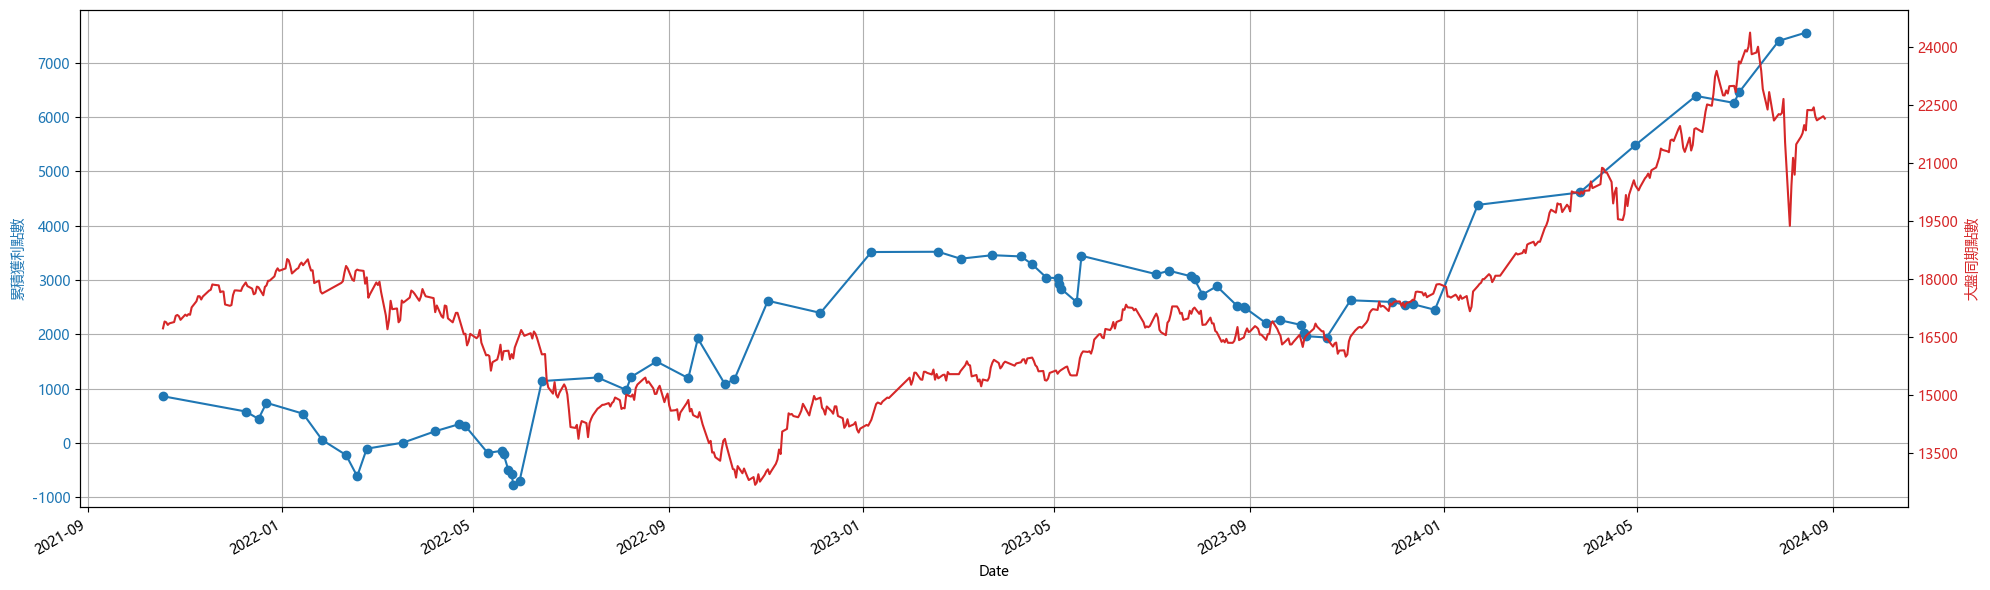

In [86]:
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.ticker import MaxNLocator

print_data = earm_data2_bs2

# 同期大盤資料 
tx_df = merged_df[( merged_df['Date'] >=  print_data['buy_date'].iloc[0]) & (merged_df['Date'] <= print_data['sell_date'].iloc[-1])]

print('===大盤累積====')
print(tx_df['最後成交價'].iloc[-1] - tx_df['最後成交價'].iloc[0])

print('===外資小兒法累積====')
print(print_data['earn'].cumsum().iloc[-1])

print('===進出次數====')
print(len(print_data))

print('===第一次買進===')
print(print_data['buy_date'].iloc[0])

print('===最後一次賣出===')
print(print_data['sell_date'].iloc[-1])

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題


# 假設 'Date' 已經是日期格式
fig, ax1 = plt.subplots(figsize=(20, 6))

# 第一條線 - 最後成交價
ax1.set_xlabel('Date')
ax1.set_ylabel('累積獲利點數', color='tab:blue')
ax1.plot(print_data['buy_date'], print_data['earn'].cumsum(), color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 開啟網格
ax1.grid(True)
# 調整 Y 軸間距 (設定更多標籤)
ax1.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 建立第二個Y軸
ax2 = ax1.twinx()  
ax2.set_ylabel('大盤同期點數', color='tab:red')  # 可以根據需要調整標籤
ax2.plot(tx_df['Date'], tx_df['最後成交價'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# 調整第二個 Y 軸間距 (同樣設定更多標籤)
ax2.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 旋轉日期標籤
fig.autofmt_xdate()

# 顯示圖表
fig.tight_layout()
plt.show()


In [204]:
earm_data2['cumsum'] = earm_data2['earn'].cumsum()
earm_data2

,today_str,buy_date,sell_date,buy_open,sell_open,earn,cumsum
0,2021-10-15,2021-10-18,2021-11-23,16800.0,17659.0,859.0,859.0
1,2021-12-08,2021-12-09,2021-12-14,17886.0,17605.0,-281.0,578.0
2,2021-12-16,2021-12-17,2021-12-20,17716.0,17580.0,-136.0,442.0
3,2021-12-21,2021-12-22,2022-01-07,17847.0,18143.0,296.0,738.0
4,2022-01-13,2022-01-14,2022-01-18,18549.0,18349.0,-200.0,538.0
5,2022-02-09,2022-02-10,2022-02-15,18230.0,17953.0,-277.0,261.0
6,2022-02-16,2022-02-17,2022-02-22,18269.0,17878.0,-391.0,-130.0
7,2022-03-17,2022-03-18,2022-04-01,17441.0,17554.0,113.0,-17.0
8,2022-04-21,2022-04-22,2022-04-22,16862.0,16992.0,130.0,113.0
9,2022-05-18,2022-05-19,2022-05-19,15871.0,15911.0,40.0,153.0


In [87]:

# test = merged_df[merged_df['Date'].isin(earm_data1['buy_date'])][['Date', '開盤價' ,'最後成交價' ,'10MA','20MA']]

# test['開10'] = test['開盤價'] - test['10MA']
# test['收10'] = test['最後成交價'] - test['10MA']
# test


In [205]:
import numpy as np
import warnings
# 計算訊號出來 外資小兒翻多單
# 出場訊號出來後 隔天開盤直接賣
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

MA = '10MA'

tx_df_raw = tx_df_raw[tx_df_raw[MA] != 0]
# tx_df_raw[tx_df_raw['最後成交價'] >= tx_df_raw['10MA']]

# tif_investors_df_raw['小外資變化'] = tif_investors_df_raw['小外資'].diff(1)

tif_investors_df_raw.dropna()

# 使用 'Date' 欄位進行內部連接
merged_df = pd.merge(tif_investors_df_raw, tx_df_raw, on='Date', how='inner')

merged_df['hold'] = np.nan

# 改成小外資多單的話進場
condition_buy = ((merged_df['最後成交價'] >=  merged_df[MA]) & (merged_df['小外資'] > 0))

condition_sell = (merged_df['最後成交價'] <  merged_df[MA])

merged_df.loc[condition_buy, 'hold'] = 1
merged_df.loc[condition_sell, 'hold'] = 0

merged_df['hold'].ffill(inplace=True)
merged_df['hold'] = merged_df['hold'].fillna(0)

# 計算進出

day_list = merged_df['Date'].unique().tolist()
earm_data3 = pd.DataFrame(columns=['buy_date','sell_date','buy_open','sell_open','earn'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = merged_df[merged_df['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天
                #隔天開盤價買進
                buy_open = merged_df[merged_df['Date'] > today_str]['開盤價'].iloc[0] 
                buy_date = merged_df[merged_df['Date'] > today_str]['Date'].iloc[0] 


                #跌破ma當天
                sell_open = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['最後成交價'].iloc[0] 
                sell_date = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['Date'].iloc[0] 
                sell_date = pd.to_datetime(sell_date)

                earn = sell_open - buy_open

                result_df = pd.DataFrame({
                        'buy_date': [buy_date],
                        'sell_date': [sell_date],
                        'buy_open': [buy_open],
                        'sell_open': [sell_open],
                        'earn': [earn]
                        })

                # 删除全为NA的列，避免可能出现的警告
                result_df.dropna(axis=1, how='all', inplace=True)

                if not result_df.empty:
                        earm_data3 = pd.concat([earm_data3, result_df], ignore_index=True)

        


In [208]:
earm_data3['earncumsum'] = earm_data3['earn'].cumsum()
earm_data3



,buy_date,sell_date,buy_open,sell_open,earn,earncumsum
0,2022-07-14,2022-08-02,14237.0,14643.0,406.0,406.0
1,2022-08-08,2022-08-22,14937.0,15175.0,238.0,644.0
2,2022-09-13,2022-09-14,14884.0,14577.0,-307.0,337.0
3,2022-09-16,2022-09-16,14500.0,14483.0,-17.0,320.0
4,2022-10-06,2022-10-11,13932.0,13091.0,-841.0,-521.0
5,2022-10-28,2022-10-28,12855.0,12764.0,-91.0,-612.0
6,2022-11-01,2022-11-28,12960.0,14475.0,1515.0,903.0
7,2022-11-30,2022-12-06,14640.0,14675.0,35.0,938.0
8,2022-12-16,2022-12-16,14440.0,14461.0,21.0,959.0
9,2023-01-06,2023-02-15,14278.0,15398.0,1120.0,2079.0


===大盤累積====
7757.0
===外資小兒法累積====
6370.0
===進出次數====
32
===第一次買進===
2022-07-14 00:00:00
===最後一次賣出===
2024-08-27 00:00:00


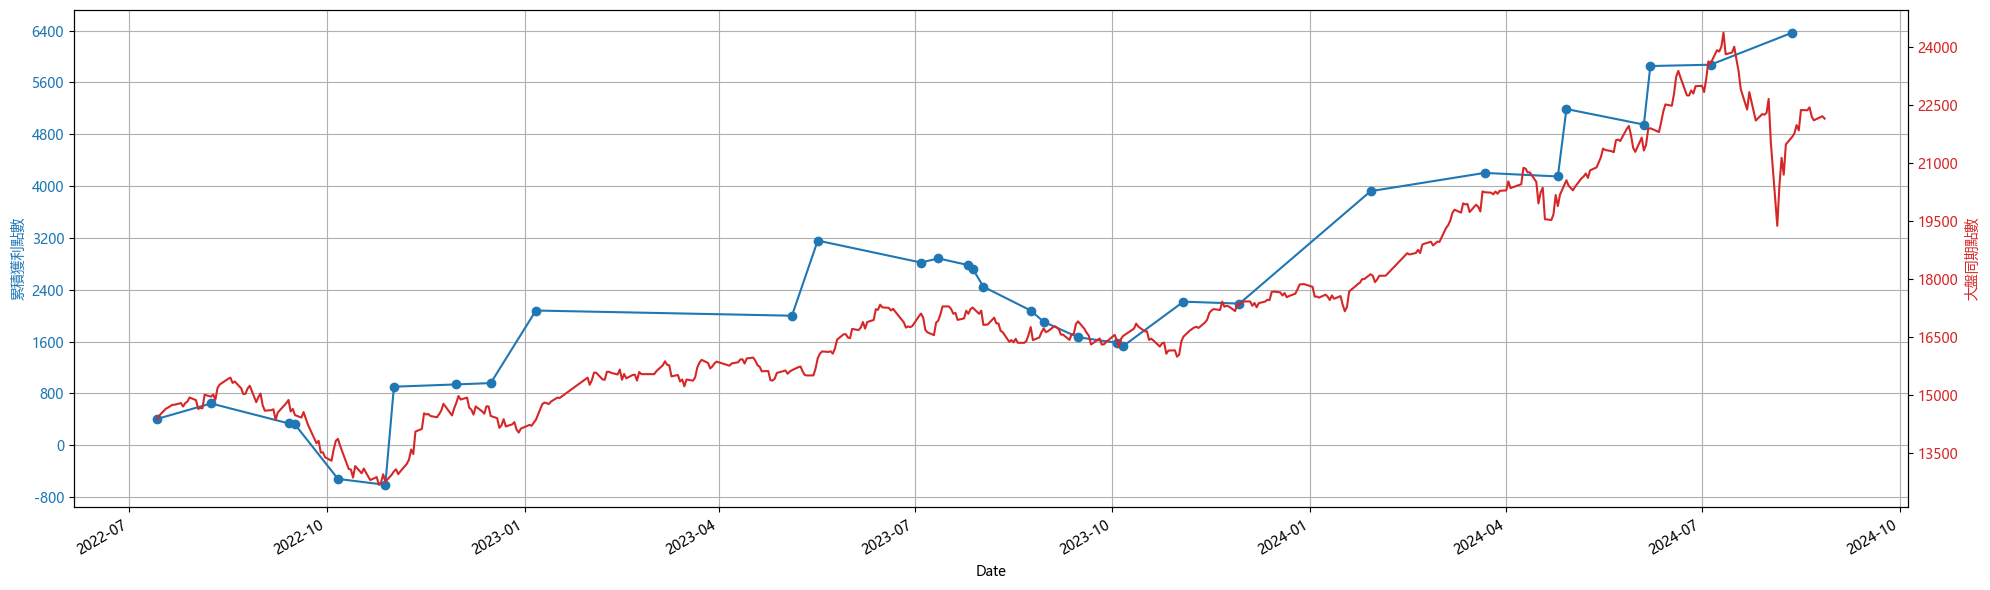

In [207]:
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.ticker import MaxNLocator

# 同期大盤資料 
tx_df = merged_df[( merged_df['Date'] >=  earm_data3['buy_date'].iloc[0]) & (merged_df['Date'] <= earm_data3['sell_date'].iloc[-1])]

print('===大盤累積====')
print(tx_df['最後成交價'].iloc[-1] - tx_df['最後成交價'].iloc[0])

print('===外資小兒法累積====')
print(earm_data3['earn'].cumsum().iloc[-1])

print('===進出次數====')
print(len(earm_data3))

print('===第一次買進===')
print(earm_data3['buy_date'].iloc[0])

print('===最後一次賣出===')
print(earm_data3['sell_date'].iloc[-1])

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題


# 假設 'Date' 已經是日期格式
fig, ax1 = plt.subplots(figsize=(20, 6))

# 第一條線 - 最後成交價
ax1.set_xlabel('Date')
ax1.set_ylabel('累積獲利點數', color='tab:blue')
ax1.plot(earm_data3['buy_date'], earm_data3['earn'].cumsum(), color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 開啟網格
ax1.grid(True)
# 調整 Y 軸間距 (設定更多標籤)
ax1.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 建立第二個Y軸
ax2 = ax1.twinx()  
ax2.set_ylabel('大盤同期點數', color='tab:red')  # 可以根據需要調整標籤
ax2.plot(tx_df['Date'], tx_df['最後成交價'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# 調整第二個 Y 軸間距 (同樣設定更多標籤)
ax2.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 旋轉日期標籤
fig.autofmt_xdate()

# 顯示圖表
fig.tight_layout()
plt.show()
